### Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
from os.path import basename, dirname, isdir, isfile, join
from tqdm.notebook import tqdm

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# root = "/Volumes/hd_4tb/results/training/*/*"
# dfs = list()
# files = sorted(glob(root))
# for folder in tqdm(files):
#     df = pd.read_csv(join(folder, "norm_simple.csv"))
#     df["pred"] = np.load(join(folder, "pred.npy"))
#     dfs.append(df)
    
# df = pd.concat(dfs)
# df.reset_index(drop=True).to_feather("/Volumes/hd_4tb/results/summary/norm_all.feather")

# files = glob("/Volumes/hd_4tb/results/training/0110/*/norm_simple.csv")
# dfs = list()
# for f in files:
#     df = pd.read_csv(f)
#     df["pred"] = np.load(join(dirname(f), "pred.npy"))
#     dfs.append(df)

# df = pd.concat(dfs)
# train_y = df.pop("pred")
# preds = lgbm_model.predict(df)
# guess = (df["next"] + df["prev"]) / 2
# np.mean(np.abs(train_y - preds)), np.mean(np.abs(train_y - guess))
# np.std(np.abs(train_y - preds)), np.std(np.abs(train_y - guess))

### Split data

<div hidden>
# root = "/Volumes/hd_4tb/results/training/*/*"
# dfs = list()
# for folder in tqdm(glob(root)):
#     df = pd.read_csv(join(folder, "simple.csv"))
#     df["pred"] = np.load(join(folder, "pred.npy"))
#     dfs.append(df)
    
# df = pd.concat(dfs)
</div>

In [2]:
!pip install -U feather-format

     |████████████████████████████████| 40.5MB 12.1MB/s eta 0:00:01
  Created wheel for feather-format: filename=feather_format-0.4.0-cp37-none-any.whl size=3013 sha256=d02a936a36ae6b9e348ba822f2649b6b413a84e05ab1bc5378cf41ca4194c4cc
  Stored in directory: /Users/pstetz/Library/Caches/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
Successfully built feather-format
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
df = pd.read_feather("/Users/pstetz/Desktop/confidential/.project/summary/norm_all.feather")
# df = df.sample(frac=1)
# df = df.reset_index(drop=True)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ImportError: the feather-format library is not installed
you can install via conda
conda install feather-format -c conda-forge
or via pip
pip install -U feather-format


In [ ]:
df.

In [3]:
features = [c for c in df.columns if "next" not in c]
df = df[features]

In [4]:
train_x, test_x = train_test_split(df, random_state=5, train_size=0.80)
train_y = train_x.pop("pred")
test_y = test_x.pop("pred")

### Training

run 1
```
'param_grid': {
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [30, 55, 85],
    'min_split_gain': [0.05, 0.3],
    'min_data_in_leaf': [40, 100]
}

{'learning_rate': 0.1, 'min_data_in_leaf': 100, 'min_split_gain': 0.3, 'num_leaves': 85}
```

run 2
```
params = {
    "learning_rate": [0.1, 0.3],
    "num_leaves": [70, 85, 100],
    "min_split_gain": [0.25, 0.3, 0.35],
    "min_data_in_leaf": [80, 100, 120, 150]
    "n_estimators": [80, 100, 125]
}

0.6304165320899651
{'learning_rate': 0.1, 'min_data_in_leaf': 80, 'min_split_gain': 0.3, 'n_estimators': 125, 'num_leaves': 85}
```

In [5]:
params = {
#     "num_iteration": [3000, 4000, 4500],
#     'max_depth': [5, 7, 15], 
#     'reg_alpha': [0, 0.1], 'reg_lambda': [0.1, 1], 
    "learning_rate": [0.05, 0.1, 0.15],
    "min_split_gain": [0.2, 0.25], #"min_data_in_leaf": [60], #'min_child_weight': 4,
#     "n_estimators": [125] #, "feature_fraction": 0.5
}
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mean_absolute_error",
    learning_rate=0.1,
    min_data_in_leaf=60,
    min_split_gain=0.25,
    n_estimators=125,
#     num_leaves=85,
    max_depth=-1,
)
# gs = GridSearchCV(model, param_grid=params, cv=5, verbose=10, scoring=mae_scorer)
model.fit(train_x, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=60,
              min_split_gain=0.25, n_estimators=125, n_jobs=-1, num_leaves=31,
              objective='mean_absolute_error', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

### Cross validate

In [45]:
### Best params
# {'fit_time': array([149.57872677, 132.186064  , 118.14307714, 101.72288799, 96.91477895]),
# 'score_time': array([9.24196792, 8.93173075, 8.33526087, 9.01005602, 7.21525717]),
# 'test_score': array([-0.62940211, -0.6296197 , -0.63166309, -0.62816857, -0.62786861])}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mse",
    learning_rate=0.05,
    min_data_in_leaf=80,
    min_split_gain=0.3,
    n_estimators=130,
    num_leaves=90,
    max_depth=-1,
)

cross_validate(model, train_x, train_y, cv=5, scoring=mse_scorer)

{'fit_time': array([16.28457785, 21.97705793, 29.57167625, 30.89967799, 20.19947004]),
 'score_time': array([0.59632802, 0.50218415, 0.52898574, 0.85004783, 0.46883893]),
 'test_score': array([-0.69077921, -0.68144191, -0.68156026, -0.68215386, -0.67898879])}

### Save model

In [15]:
model_filepath = "/Users/pstetz/Desktop/confidential/.project/run/lgbm/4_mae.pkl"

if not isdir(dirname(model_filepath)):
    os.makedirs(dirname(model_filepath))
    
with open(model_filepath, 'wb') as f:
    pickle.dump(model, f)

### Score

In [14]:
models = {
    "LGBM": 0.6284996600820217,
    "mean": 0.7366437115221597,
    "zero": 0.9657811137265954,
    "linear": 0.6542259996615196,
    "CNN": "under developement"
}

In [8]:
expected = model.predict(test_x)
score = mean_absolute_error(test_y, expected)
print(score)

0.6456031830005203


In [10]:
mean_squared_error(test_y, np.zeros(test_y.shape))

0.965609011645813

In [9]:
# mean_absolute_error(test_y, (test_x["next"] + test_x["prev"]) / 2)
mean_absolute_error(test_y, test_x["prev"])

0.7511985452213019

0.6001293911786997


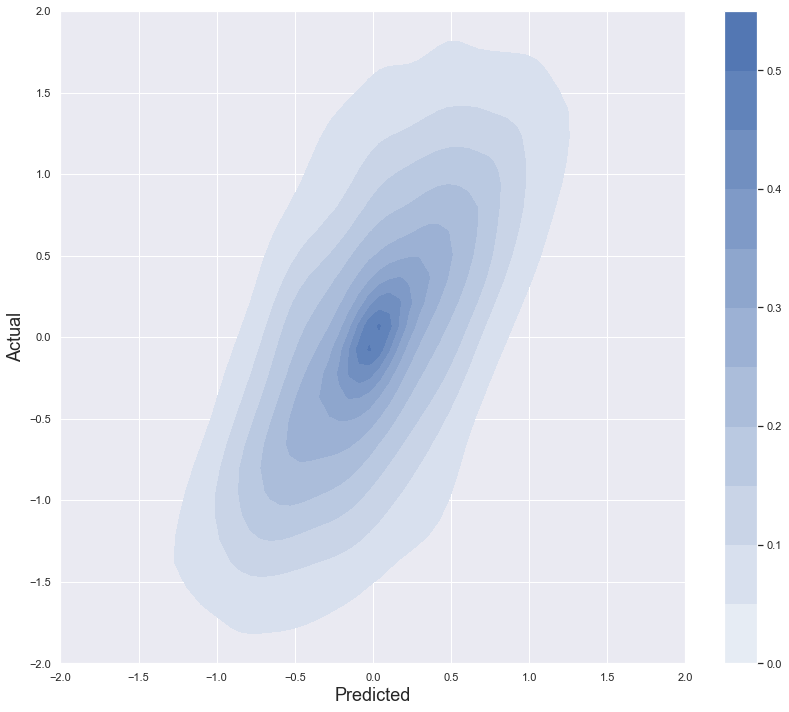

In [20]:
print(score)
N = 10000
fig, ax = plt.subplots(figsize=(14, 12))
# ax.plot(expected, test_y, ".", markersize=0.1)
sns.kdeplot(expected[:N], test_y[:N], shade=True, shade_lowest=False, cbar=True)
plt.xlabel("Predicted", fontsize=18)
plt.ylabel("Actual", fontsize=18)
plt.xlim([-2, 2])
plt.ylim([-2, 2]);

### Feature importance

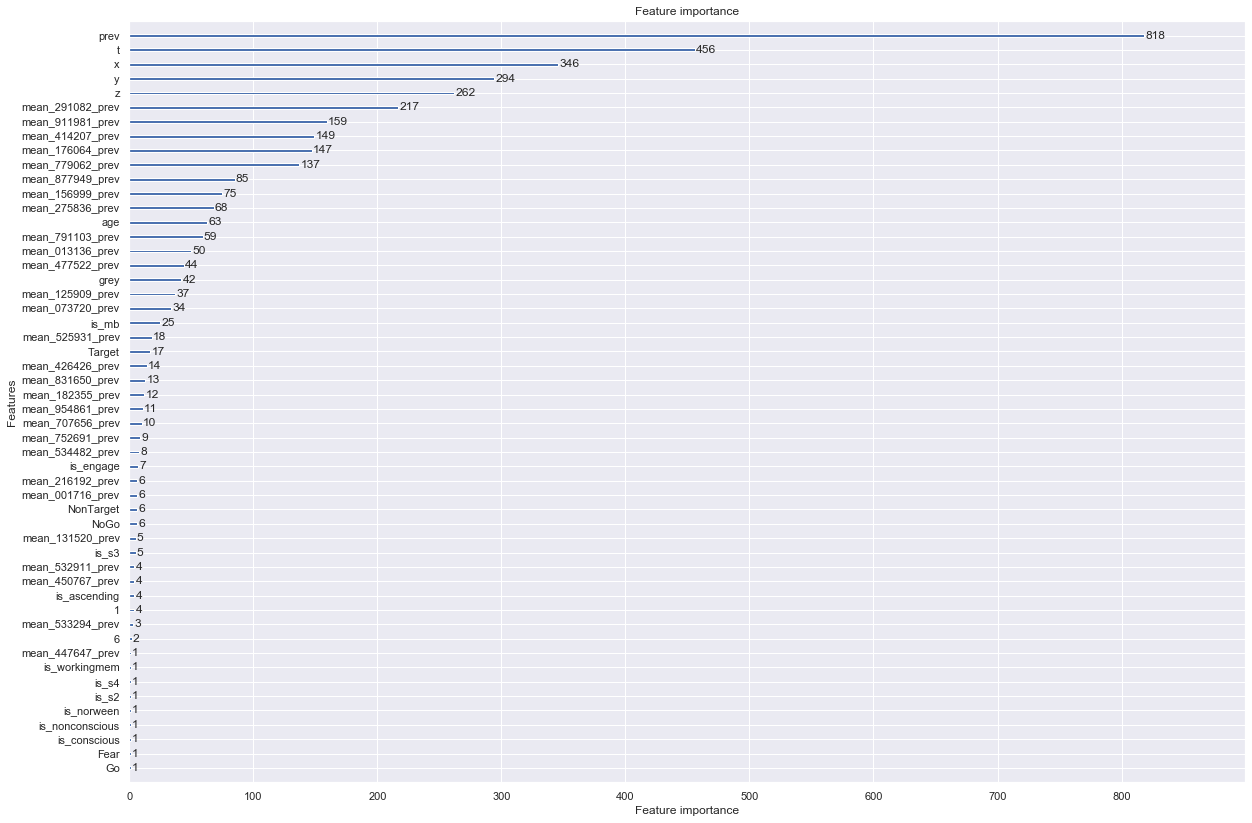

In [7]:
fig, ax = plt.subplots(figsize=(20, 14))
lgb.plot_importance(model, ax=ax);

### Noise cloud

In [1]:
tmp = {"feature": [], "score": []}
for c, s in zip(train_x.columns, model.feature_importances_):
    tmp["feature"].append(c)
    tmp["score"].append(s)

scores = pd.DataFrame(tmp)
scores.sort_values("score", ascending=False, inplace=True)

NameError: name 'train_x' is not defined

In [21]:
features = [
    ["next"],
    ["next", "prev"],
    ["next", "prev", "t", "y", "x", "z"],
    ["next", "prev", "t", "y", "x", "z", "age", "mean_831650_next", "mean_216192_next", "mean_911981_next", "mean_911981_prev"],
    train_x.columns
]
predictions = dict()
for feats in features:
    if "model" in locals(): del model
    model = lgb.LGBMRegressor(
        boosting_type="gbdt",
        objective="mse",
        learning_rate=0.05,
        min_data_in_leaf=80,
        min_split_gain=0.3,
        n_estimators=130,
        num_leaves=90,
        max_depth=-1,
    )
    model.fit(train_x[feats], train_y)
    predictions[len(feats)] = model.predict(test_x[feats])

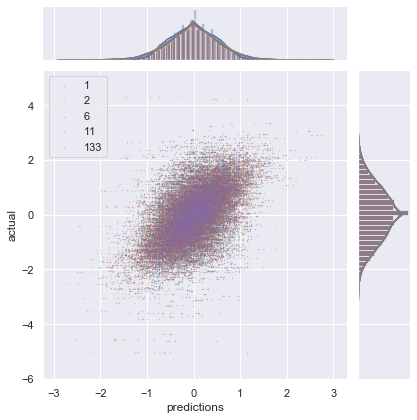

In [33]:
N = 10000
dfs = list()
for n in predictions.keys():
    tmp_df = pd.DataFrame({"predictions": predictions[n][:N], "actual": test_y[:N]})
    tmp_df["kind"] = n
    dfs.append(tmp_df)

spread = pd.concat(dfs)

### Accuracy over models

In [82]:
tasks = [
    ("is_workingmem", True, "workingmemoryMB"),
    ("is_nonconscious", False, "nonconscious"),
    ("is_gonogo", False, "gonogo"),
    ("is_conscious", False, "conscious"),
    ("is_workingmem", False, "workingmemorySB"),
]

task_score = {"task": [], "diff": [], "std": [], "N": []}
for task, is_mb, name in tasks:
    if is_mb:
        indexes = np.all([test_x[task] > 0, test_x["is_mb"] > 0], axis=0)
    else:
        indexes = np.all([test_x[task] > 0, test_x["is_mb"] < 0], axis=0)
    task_x = test_x[indexes]
    task_y = test_y[indexes]
    preds = model.predict(task_x)
    diff = np.mean(np.abs(task_y - preds))
    _std = np.std(task_y - preds)
    task_score["task"].append(name)
    task_score["diff"].append(diff)
    task_score["std"].append(_std)
    task_score["N"].append(len(task_y))
    
pd.DataFrame(task_score)

,task,diff,std,N
0,workingmemoryMB,0.635283,0.825949,72310
1,nonconscious,0.586101,0.778374,172853
2,gonogo,0.590789,0.785887,179851
3,conscious,0.599443,0.796551,168889
4,workingmemorySB,0.592388,0.777856,33630
